This tutorial demonstrates how to use `cryojax` to build a scattering potential from a PDB entry, simulate projections, and save the result.

The scattering potential will be built using the tabulation of atomic scattering factors from the work of Lian-Mao Peng, which fits the potential from single atoms to a sum of five gaussians. See the `cryojax` documentation [here](../api/simulator/volume.md#atom-based-volumes) for more information.

*References:*

- Peng, L-M., et al. "Robust parameterization of elastic and absorptive electron atomic scattering factors." Acta Crystallographica Section A: Foundations of Crystallography 52.2 (1996): 257-276.
- Himes, Benjamin, and Nikolaus Grigorieff. "Cryo-TEM simulations of amorphous radiation-sensitive samples using multislice wave propagation." IUCrJ 8.6 (2021): 943-953.

In [1]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

First, load the atomic positions and identities from a PDB entry. Here, a structure of GroEL (PDB ID 5w0s) is used. This is loaded into a `GaussianMixtureVolume` object.

In [2]:
import cryojax.simulator as cxs


atom_volume = cxs.load_tabulated_volume(
    "./data/5w0s.pdb",
    tabulation="peng",
    output_type=cxs.GaussianMixtureVolume,
)
print(atom_volume)

GaussianMixtureVolume(
  positions=f32[54021,3], amplitudes=f32[54021,5], variances=f32[54021,5]
)


We see above that the `GaussianMixtureVolume` includes 

- The `positions` are the positions of the atoms in Angstroms.
- The `amplitudes`, and `variances` are the parameters $a_i$ and $b_i$ from Peng et al. (1996) up to numerical constants (see documentation for details).

Optionally, we can also load PDB B-factors into the `b_factors` field using

```python
atom_volume = cxs.load_tabulated_volume(..., include_b_factors=True)
```

Next, we can build the voxel grid representation of the potential.

In [3]:
import equinox as eqx


# Evaluate the potential on a voxel grid
shape = (80, 80, 80)
voxel_size = 3.0


@eqx.filter_jit
def compute_voxels(atom_volume: cxs.GaussianMixtureVolume):
    render_fn = cxs.AutoVolumeRenderFn(shape, voxel_size)
    return cxs.render_voxel_volume(atom_volume, render_fn=render_fn)


voxel_volume = compute_voxels(atom_volume)
print(voxel_volume)

FourierVoxelGridVolume(
  fourier_voxel_grid=c64[80,80,80], frequency_slice_in_pixels=f32[1,80,80,3]
)


!!! info
    In, `cryojax`, potentials are built in units of *inverse length squared*,
    $[L]^{-2}$. This rescaled potential is defined to be

    $$U(x, y, z) = \frac{m_0 e}{2 \pi \hbar^2} V(x, y, z),$$

    where $V$ is the electrostatic potential energy, $(x, y, z)$ are positional
    coordinates, $m_0$ is the electron rest mass, and $e$ is the electron charge.

    In the following, we will compute projections of the potential, which we will
    define to be

    $$U_z(x, y) = \int_{-\infty}^z dz' \ U(x, y, z'),$$

    where in practice the integration domain is taken to be between $z'$-planes above and below where the potential has sufficiently decayed. In this tutorial, this integral is computed with fourier slice extraction.

Now, let's validate that what we see is reasonable. The first validation step is to compute a few different projections of the potential.

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Projected potential, $U_z(x, y)$'}>)

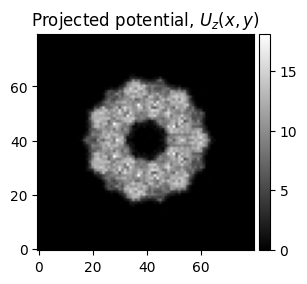

In [4]:
import equinox as eqx


@eqx.filter_jit
def compute_projection(volume, image_config, pose):
    """Compute a projection of a voxel-based potential."""
    # ... compute the integrated potential
    image_model = cxs.make_image_model(volume, image_config, pose)
    return image_model.simulate()


# Set the image configuration, the pose, and compute
image_config = cxs.BasicImageConfig(
    shape=voxel_volume.shape[0:2],
    pixel_size=voxel_size,
    voltage_in_kilovolts=300.0,
)
pose = cxs.EulerAnglePose(phi_angle=0.0, theta_angle=0.0, psi_angle=0.0)
projected_potential = compute_projection(voxel_volume, image_config, pose)
# ... and plot
fig, ax = plt.subplots(figsize=(3, 3))
plot_image(projected_potential, fig, ax, label="Projected potential, $U_z(x, y)$")

We can inspect a different viewing angles by rotating the `voxel_volume` to a different pose. This involves instantiating a `cryojax` representation of a pose, which here is the [`cryojax.simulator.EulerAnglePose`][].

(<Figure size 300x300 with 2 Axes>,
 <Axes: title={'center': 'Integrated potential, $U_z(x, y)$'}>)

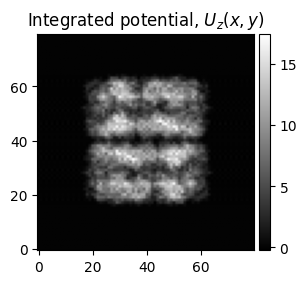

In [5]:
# Simulate at a different pose
pose = cxs.EulerAnglePose(phi_angle=0.0, theta_angle=90.0, psi_angle=90.0)
projected_potential = compute_projection(voxel_volume, image_config, pose)
fig, ax = plt.subplots(figsize=(3, 3))
plot_image(projected_potential, fig, ax, label="Integrated potential, $U_z(x, y)$")

Another good sanity check is to check that the potential is relatively weak compared to a typical incident electron beam energy in cryo-EM. For an electron beam with incident wavenumber $k$, this can be checked with the condition

$$4 \pi U / k^2 << 1,$$

where again $U = m_0 e V / 2 \pi \hbar^2$ is the rescaled potential. Below, we consider an incident energy of $300 \ \textrm{keV}$.

In [6]:
import jax.numpy as jnp
import numpy as np
from cryojax.constants import wavelength_from_kilovolts
from cryojax.ndimage import ifftn


fourier_to_real_voxels = lambda x: ifftn(jnp.fft.ifftshift(x)).real

# First compute the wavenumber
voltage_in_kilovolts = 300.0
wavelength_in_angstroms = wavelength_from_kilovolts(voltage_in_kilovolts)
wavenumber = 2 * np.pi / wavelength_in_angstroms
# ... now get the maximum value of the potential
real_voxel_grid = fourier_to_real_voxels(voxel_volume.fourier_voxel_grid)
potential_maximum = real_voxel_grid.max()
# ... and compare
print(4 * np.pi * potential_maximum / wavenumber**2)

4.9315273e-05


Looks reasonable! Finally, we run the following to write the voxel grid to disk for later processing.

```python
from cryojax.io import write_volume_to_mrc


write_volume_to_mrc(
    real_voxel_grid,
    voxel_size,
    "./data/groel_5w0s_scattering_potential.mrc",
    overwrite=True,
)
```